In [1]:
! python -m pip install -q towhee gradio opencv-python

/usr/bin/python: No module named pip


### Prepare the data

In [2]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip -O
! unzip -q -o reverse_image_search.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  9964k      0  0:00:12  0:00:12 --:--:-- 11.1M


In [1]:


import pandas as pd

df = pd.read_csv('reverse_image_search.csv')
df.head()



,id,path,label
0,0,./train/brain_coral/n01917289_1783.JPEG,brain_coral
1,1,./train/brain_coral/n01917289_4317.JPEG,brain_coral
2,2,./train/brain_coral/n01917289_765.JPEG,brain_coral
3,3,./train/brain_coral/n01917289_1079.JPEG,brain_coral
4,4,./train/brain_coral/n01917289_2484.JPEG,brain_coral


In [2]:


import cv2
from towhee.types.image import Image

id_img = df.set_index('id')['path'].to_dict()
def read_images(results):
    imgs = []
    for re in results:
        path = id_img[re.id]
        imgs.append(Image(cv2.imread(path), 'BGR'))
    return imgs



### Create a Milvus Collection

In [3]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

def create_milvus_collection(collection_name, dim):
    connections.connect(host='127.0.0.1', port='19530')
    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='path', dtype=DataType.VARCHAR, description='path to image', max_length=500, 
                    is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='text image search')
    collection = Collection(name=collection_name, schema=schema)

    # create IVF_FLAT index for collection.
    index_params = {
        'metric_type':'L2',
        'index_type':"IVF_FLAT",
        'params':{"nlist":512}
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection

#collection = create_milvus_collection('text_image_search', 512)

In [4]:
from pymilvus import Collection, utility
connections.connect(host='127.0.0.1', port='19530')

collection = create_milvus_collection('text_image_search', 512)

## Text Image Search

In [5]:


from towhee import ops, pipe, DataCollection
import numpy as np



img,vec
,"[0.03724054, -0.06598868, -0.010860419, ...] shape=(512,)"

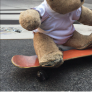

In [6]:


p = (
    pipe.input('path')
    .map('path', 'img', ops.image_decode.cv2('rgb'))
    .map('img', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='image'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .output('img', 'vec')
)

DataCollection(p('./teddy.png')).show()



In [7]:


p2 = (
    pipe.input('text')
    .map('text', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='text'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .output('text', 'vec')
)

DataCollection(p2("A teddybear on a skateboard in Times Square.")).show()



text,vec
A teddybear on a skateboard in Times Square.,"[-0.008685378, 0.027176848, -0.0007425783, ...] shape=(512,)"


### Load Image Embeddings into Milvus

In [8]:
%%time
collection = create_milvus_collection('text_image_search', 512)

def read_csv(csv_path, encoding='utf-8-sig'):
    import csv
    with open(csv_path, 'r', encoding=encoding) as f:
        data = csv.DictReader(f)
        for line in data:
            yield int(line['id']), line['path']

p3 = (
    pipe.input('csv_file')
    .flat_map('csv_file', ('id', 'path'), read_csv)
    .map('path', 'img', ops.image_decode.cv2('rgb'))
    .map('img', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='image', device=0))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .map(('path', 'vec'), (), ops.ann_insert.milvus_client(host='127.0.0.1', port='19530', collection_name='text_image_search'))
    .output()
)

ret = p3('reverse_image_search.csv')

CPU times: user 23.4 s, sys: 9.22 s, total: 32.6 s
Wall time: 17.6 s


In [9]:
collection.load()

In [10]:
print('Total number of inserted data is {}.'.format(collection.num_entities))

Total number of inserted data is 0.


In [11]:
from pymilvus import utility
utility.list_collections()

['text_image_search',
 'reverse_image_search',
 'text_image_search_blip',
 'image_search_collection']

###  Query Matched Images from Milvus


In [20]:
import pandas as pd
import cv2

def read_image(image_ids):
    df = pd.read_csv('reverse_image_search.csv')
    id_img = df.set_index('id')['path'].to_dict()
    paths = []
    decode = ops.image_decode.cv2('rgb')
    for image_id in image_ids:
        path = id_img[image_id]
        paths.append(path)
    return paths


p4 = (
    pipe.input('text')
    .map('text', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='text'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .map('vec', 'result', ops.ann_search.milvus_client(host='127.0.0.1', port='19530', collection_name='text_image_search', limit=5))
    .map('result', 'image_ids', lambda x: [item[0] for item in x])
    #.map('image_ids', 'images', read_image)
    .output('text', 'image_ids')
)

DataCollection(p4("A variety of fruits")).show()
DataCollection(p4("jeans")).show()

text,image_ids
A variety of fruits,./train/orange/n07747607_18447.JPEG ./train/banana/n07753592_7688.JPEG ./train/orange/n07747607_11283.JPEG ./train/banana/n07753592_3043.JPEG ./train/grocery_store/n03461385_9780.JPEG


text,image_ids
jeans,./train/jean/n03594734_4800.JPEG ./train/jean/n03594734_16188.JPEG ./train/jean/n03594734_38343.JPEG ./train/jean/n03594734_24159.JPEG ./train/jean/n03594734_32813.JPEG
